In [168]:
from random import randint, randrange
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import BayesianGaussianMixture
from sim import moving_average

In [169]:
"""this class produces a timeseries dataset of a digital signal with noise. It takes a list of states and a list of probabilities of transitioning to each state. It has 600000 samples."""


class TimeSeries:
    def __init__(self, states, n_switches, length=600000):
        self.states = states
        self.n_switches = n_switches
        self.data = []
        self.labels = []
        self.length = length
        self.state = 0
        self.noise = 0.15
        self.generate(self.length)

    def generate(self, length):
        """Throughout the length of the dataset, the state will change n_switches times."""
        # pick when the state will change
        switch_points = [randint(0, length) for _ in range(self.n_switches)]
        switch_points.sort()
        switch_points.append(length)
        switch_points = [0] + switch_points
        # generate the data
        for i in range(length):
            if i in switch_points:
                self.state = randrange(len(self.states))
            # noise = normal distribution with mean 0 and std 1
            self.data.append(self.states[self.state] + np.random.normal(0, self.noise))
            self.labels.append(self.state)

    def plot(self):
        plt.figure(figsize=(30, 5))
        plt.scatter(range(len(self.data[::100])), self.data[::100], c=self.labels[::100], cmap='viridis', alpha=0.5)
        plt.show()

    def get_data(self):
        return np.array(self.data).reshape(-1, 1)

    def get_labels(self):
        return np.array(self.labels)

    def get_abf(self):
        return DataFrame({'signal': self.data, 'time': range(len(self.data)), 'labels': self.labels})

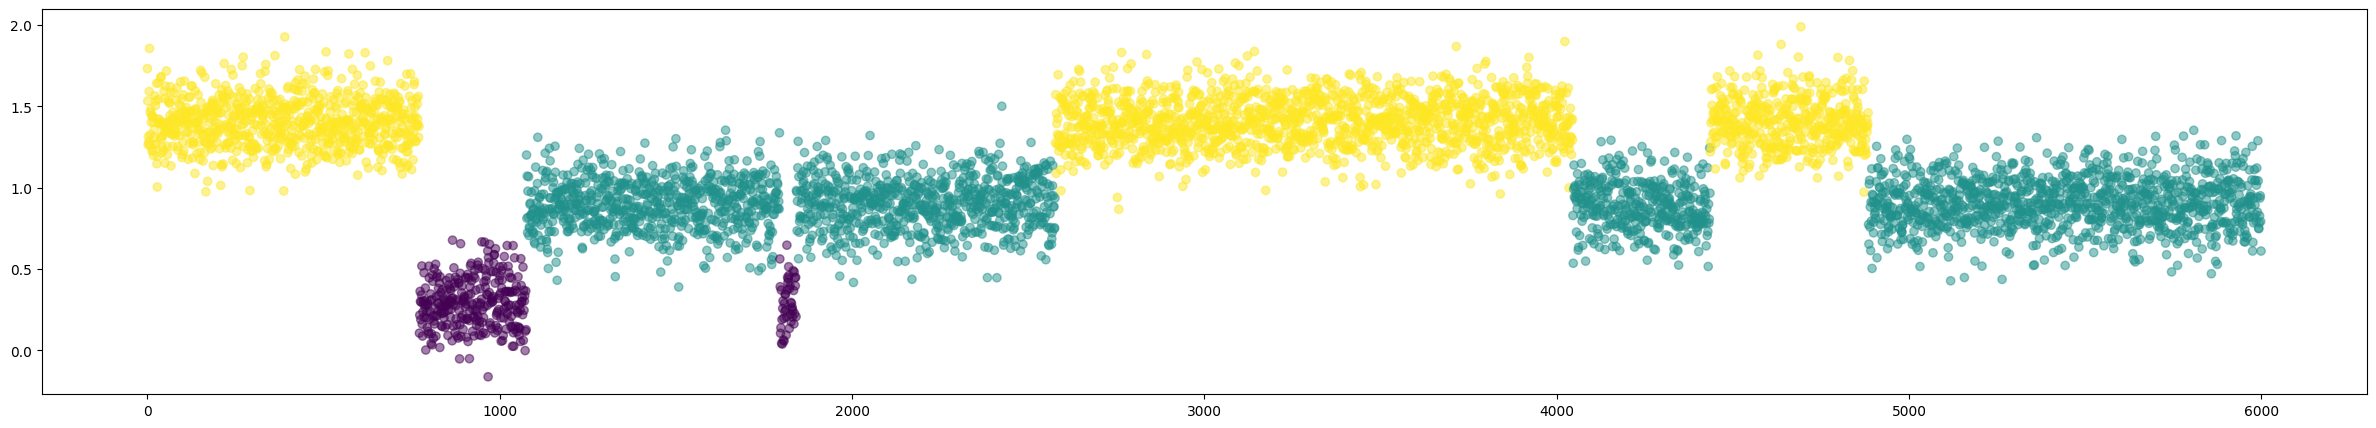

In [170]:
data = TimeSeries([.3, .9, 1.4], 10)
df = data.get_abf()
data.plot()

## Find the number of states

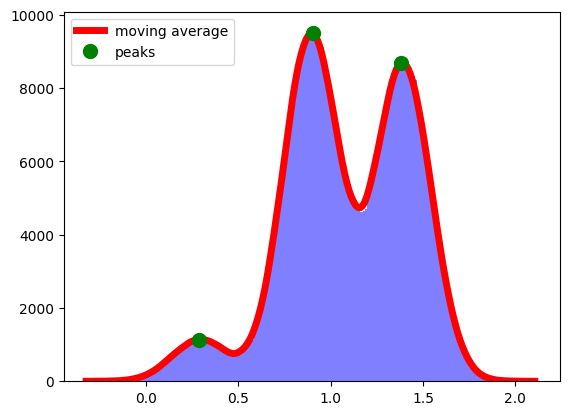

Number of states: 3


In [171]:
# df.signal find the bins distribution

bins = np.linspace(df.signal.min(), df.signal.max(), 200)
np.digitize(df.signal, bins)
# plot the bins
hists = plt.hist(df.signal, bins=bins, alpha=0.5, color='b')

# find the moving average of hists
ma = moving_average(hists[0], 5)
ma = moving_average(ma, 5)
plt.plot(hists[1][:-1], ma, 'r', linewidth=5, label='moving average')

# find number of peaks in the moving average that are above a certain threshold
threshold = 0
peaks = np.diff(np.sign(np.diff(ma))) < 0
peaks = np.where(peaks)[0] + 1
number_of_states = sum(ma[peaks] > threshold)
plt.plot(hists[1][peaks][ma[peaks] > threshold], ma[peaks][ma[peaks] > threshold], 'o', markersize=10, label='peaks',
         color='g')
plt.legend()
plt.show()

print(f'Number of states: {number_of_states}')

Number of clusters: 3


array([0, 1, 2])

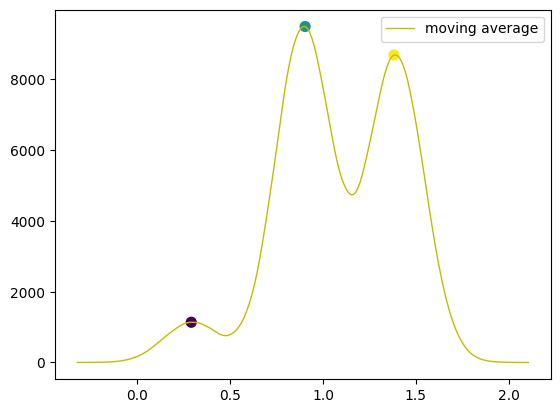

In [172]:
# DBSCAN on hists[1][peaks], ma[peaks]
peaks_coords = np.array(list(zip(hists[1][peaks], ma[peaks])))
# remove peaks that are less than the threshold
threshold = 5
peaks_coords = peaks_coords[ma[peaks] > threshold]

dbscan = DBSCAN(eps=10, min_samples=1)
dbscan.fit(peaks_coords)
labels = dbscan.labels_
n_clusters_ = len(set(labels)) # - (1 if -1 in labels else 0)
print(f'Number of clusters: {n_clusters_}')

# plot the clusters
plt.scatter(peaks_coords[:, 0], peaks_coords[:, 1], c=labels, cmap='viridis', s=50, alpha=1, marker='o')
plt.plot(hists[1][:-1], ma, 'y', linewidth=1, label='moving average', alpha=1)
plt.legend()
labels

## Classify the signal

In [173]:
bgm = BayesianGaussianMixture(n_components=n_clusters_, random_state=42).fit(df.signal.values.reshape(-1, 1))
bgm.means_

array([[0.90051043],
       [1.39976922],
       [0.29903211]])

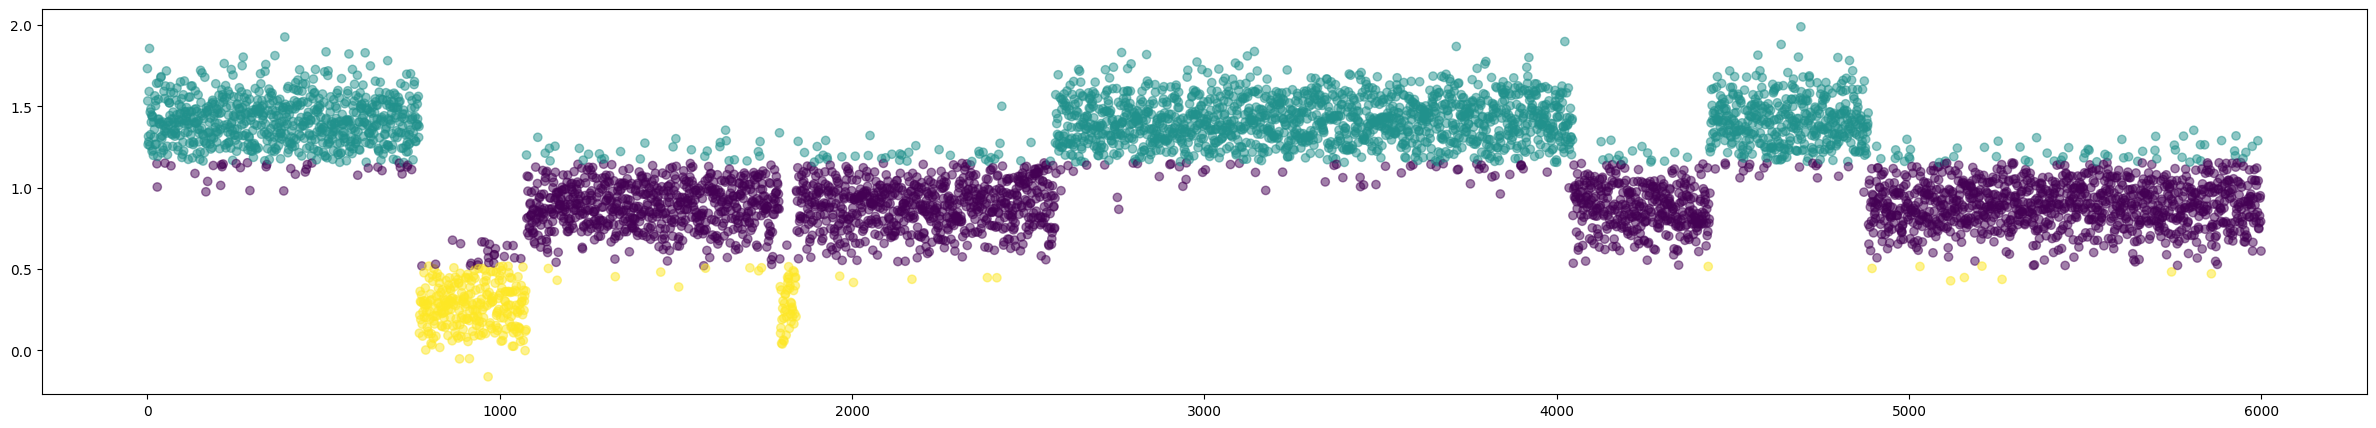

In [174]:
predicted = bgm.predict(df.signal.values.reshape(-1, 1))
df['predicted'] = predicted
conf = bgm.predict_proba(df.signal.values.reshape(-1, 1))
# desc sort conf axis
conf = np.sort(conf, axis=1)[:, ::-1]
df['conf'] = conf[:, 0]

plt.figure(figsize=(30, 5))
plt.scatter(range(len(df.signal[::100])), df.signal[::100], c=df.predicted[::100], cmap='viridis', alpha=0.5)

In [175]:
df

,signal,time,labels,predicted,conf
0,1.732984,0,2,1,0.999997
1,1.326095,1,2,1,0.977326
2,1.309940,2,2,1,0.967980
3,1.114351,3,2,0,0.710183
4,1.503741,4,2,1,0.999527
...,...,...,...,...,...
599995,0.913979,599995,1,0,0.995136
599996,0.868371,599996,1,0,0.998149
599997,1.019769,599997,1,0,0.951884
599998,0.855701,599998,1,0,0.998547


In [176]:
# find the mapping between df.predicted.value_counts() and df.labels.value_counts() based on similarity of occurences
a = df.predicted.value_counts().index
b = df.labels.value_counts().index
mapping = {}
for i in a:
    mapping[i] = b[np.argmax([np.sum(df.labels[df.predicted == i] == j) for j in b])]

df['predicted'] = df.predicted.map(mapping)
mapping

{0: 1, 1: 2, 2: 0}

In [177]:
accuracy_score(df.labels, df.predicted)

0.9483383333333333